<a href="https://colab.research.google.com/github/halilyaman/atlas-machine-learning/blob/master/CE475_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Used Techniques**

1.   Multiple Linear Regression
2.   L1 Regularization
3.   Polynomial Regression
4.   K-Nearest Neighbors
5.   Deep Neural Networks

### **Import libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import xlwt
from xlwt import Workbook

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
PATH = "drive/My Drive/IEU/CE475_project/data.csv"
data = pd.read_csv(PATH)
data.describe()

,SampleNo,x1,x2,x3,x4,x5,x6,Y
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,100.000000
mean,60.500000,18.716667,0.941667,17.066667,48.266667,0.941667,24.883333,1859.750000
std,34.785054,12.470593,11.644089,10.810618,27.596959,11.644089,14.683887,2717.641332
min,1.000000,0.000000,-20.000000,0.000000,2.000000,-20.000000,1.000000,-43.000000
25%,30.750000,8.000000,-9.000000,7.000000,22.750000,-9.000000,12.000000,0.000000
50%,60.500000,18.500000,1.000000,17.500000,48.000000,1.000000,24.000000,753.500000
75%,90.250000,29.000000,11.000000,26.500000,74.000000,11.000000,37.250000,2262.500000
max,120.000000,40.000000,20.000000,35.000000,97.000000,20.000000,50.000000,12575.000000


### **Split data into the training inputs, training outputs and test inputs**

In [0]:
training = data[:100]
test = data[100:]

training_inputs_df = training[["x1", "x2", "x3", "x4", "x5", "x6"]]
training_outputs_df = training["Y"]
test_inputs_df = test[["x1", "x2", "x3", "x4", "x5", "x6"]]

### **Data Distribution**

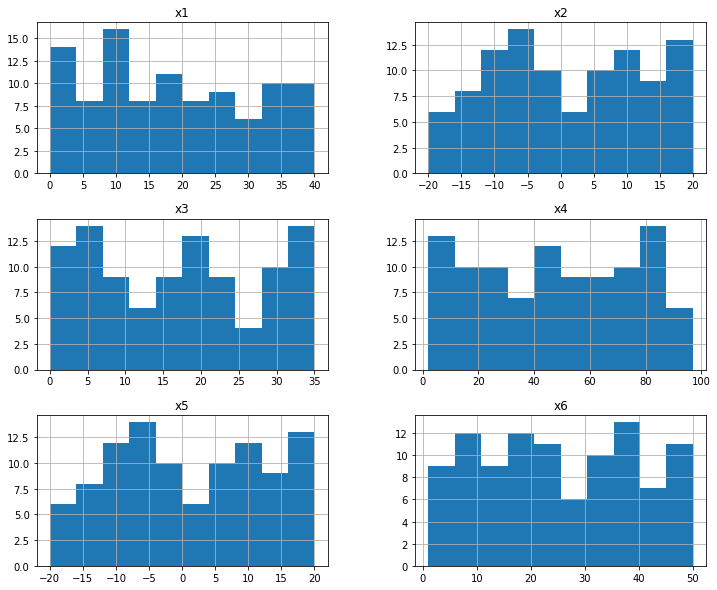

In [4]:
sub_plots = training_inputs_df.hist(figsize=(12, 10))

### **Interpretation of the Distribution**

If we analyze the distributions, we see that x2 and x5 are exactly the same. So we can drop one of them.

In [5]:
# drop the column "x5"
training_inputs_df = training_inputs_df.drop(["x5"], axis=1)
test_inputs_df = test_inputs_df.drop(["x5"], axis=1)

# convert data frames to numpy array
training_inputs = np.array(training_inputs_df)
training_outputs = np.array(training_outputs_df)
test_inputs = np.array(test_inputs_df)

# print the sizes
print("Training data size: {}".format(training_inputs.shape[0]))
print("Test data size: {}".format(test_inputs.shape[0]))

Training data size: 100
Test data size: 20


### **Correlation**

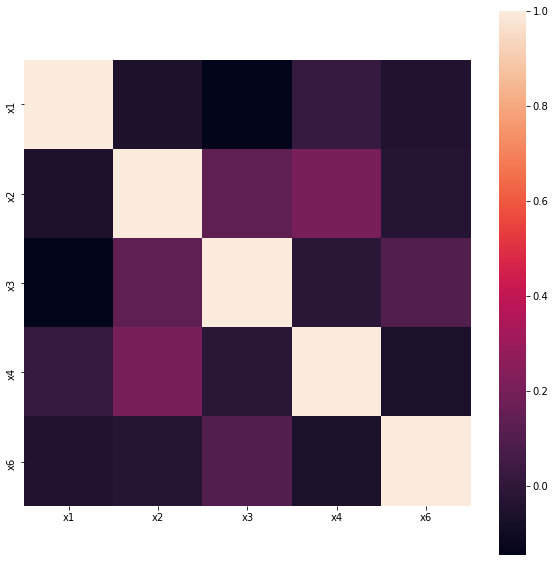

In [6]:
C_mat = training_inputs_df.corr()
fig = plt.figure(figsize=(10, 10))
sb.heatmap(C_mat, vmax=1.0, square=True)

### **Ground Truth Labels vs Predicted Labels**
Use this function for plotting the results.

In [0]:
def plot_result(pred_val, real_val):
  pred_val = pred_val.flatten()
  real_val = real_val.flatten()

  plt.scatter(pred_val, real_val)
  plt.xlabel("Predicted Values")
  plt.ylabel("Real Values")
  plt.show()
  
  sb.kdeplot(pred_val, real_val, color="blueviolet", shade=True)
  plt.xlabel("Predicted Values")
  plt.ylabel("Real Values")
  plt.show()

### **Helper functions**

In [0]:
def get_statistics(y_pred, y, n_coefs=None):

  stats = dict()

  y_mean = np.mean(y)

  rss = np.sum(np.square(y - y_pred))
  tss = np.sum(np.square(y - y_mean))

  stats["rss"] = rss
  stats["tss"] = tss
  stats["r_square"] = 1 - (rss / tss)
  stats["mse"] = np.sum(np.square(y_pred - y))
  
  if n_coefs != None:
    
    stats["f_statistic"] = ((tss - rss) / n_coefs) / (rss / (len(y) - n_coefs - 1))
    stats["adjusted_r_square"] = 1 - ((rss / (len(y) - n_coefs - 1)) / (tss / (len(y) - 1)))

  return stats

# **1. Multiple Linear Regression**
---
Scikit-learn library is used for this implementation.\
For measuring the accuracy of the model, k-fold cross validation is used.

In [0]:
def multi_lin_reg(X, y, n_splits=10):

  linear_model = LinearRegression()

  # training data is splitted into 10 folds each containing 10 data samples.
  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
  
  r_squares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):
    
    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit the training data to the model
    linear_model.fit(X_train, y_train)

    # calculate R^2 value
    r_square = linear_model.score(X_test, y_test)
    r_squares.append(r_square)

    # get the prediction results
    predictions = np.append(predictions, linear_model.predict(X_test))

  # calculate mean of r square values of each fold
  r_square = np.mean(r_squares)

  return r_square, predictions

In [218]:
# apply multiple linear regression and get the R^2 value
r_square, MLR_preds = multi_lin_reg(training_inputs, training_outputs, n_splits=4)

print("Cross Validation R^2: {}".format(r_square))

Cross Validation R^2: 0.3445325749234567


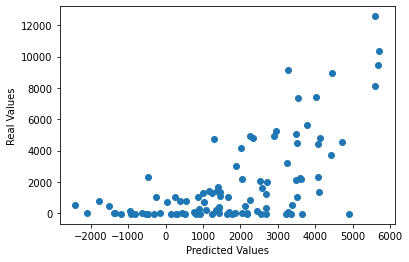

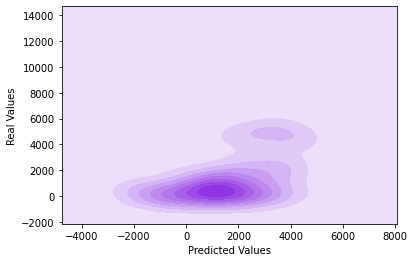

In [21]:
# plot the results
plot_result(MLR_preds, training_outputs)

**Feature Selection with Recursive Feature Elimination Method**

In [22]:
r_square_values = []
log = dict()

for i in range(len(training_inputs.T)):
  
  rfe = RFE(linear_model, i+1)
  fit = rfe.fit(training_inputs, training_outputs)

  columns = []

  for j, val in enumerate(fit.support_): 
    if val:
      columns.append(training_inputs_df.columns[j])
  
  r_square = fit.score(training_inputs, training_outputs)
  r_square_values.append(r_square)

  log[i] = dict()
  log[i]["n_feature"] = i
  log[i]["selected_features"] = columns
  log[i]["r_square"] = r_square

  print(f"Selected Features: {columns}")
  print(f"R^2: {r_square}")
  print("----------------------------------------------------------------")


best_r_square = np.max(r_square_values)
for i in range(len(log)):
  if log[i]["r_square"] == best_r_square:
    print("Best Score Features: "+str(log[i]["selected_features"]))
    print("Best R^2: "+str(log[i]["r_square"]))
    

Selected Features: ['x1']
R^2: 0.22382316839756689
----------------------------------------------------------------
Selected Features: ['x1', 'x3']
R^2: 0.3994151945695339
----------------------------------------------------------------
Selected Features: ['x1', 'x2', 'x3']
R^2: 0.4798833906569423
----------------------------------------------------------------
Selected Features: ['x1', 'x2', 'x3', 'x6']
R^2: 0.4816417573685913
----------------------------------------------------------------
Selected Features: ['x1', 'x2', 'x3', 'x4', 'x6']
R^2: 0.4817574815538422
----------------------------------------------------------------
Best Score Features: ['x1', 'x2', 'x3', 'x4', 'x6']
Best R^2: 0.4817574815538422


# **2. L1 Regularization**

In [0]:
def l1_regularization(X, y, alpha=2, n_splits=4):

  lasso = Lasso(alpha=alpha, normalize=True)

  # training data is splitted into 10 folds each containing 10 data samples.
  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  r_squares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit the training data to the model
    lasso.fit(X_train, y_train)

    # calculate R^2 value
    r_square = lasso.score(X_test, y_test)
    r_squares.append(r_square)

    # get the prediction results
    predictions = np.append(predictions, lasso.predict(X_test))

  # calculate mean of r square values
  r_square = np.mean(r_squares)

  return r_square, predictions

In [24]:
# find best alpha value for lasso
max_r_square = 0
best_alpha = 1
for i in range(1, 30):

  r_square, lasso_preds = l1_regularization(training_inputs, training_outputs, alpha=i, n_splits=4)

  print("Alpha: {}   R^2: {}".format(i, r_square))

  if r_square > max_r_square:
    
    max_r_square = r_square
    best_alpha = i

Alpha: 1   R^2: 0.3464547560992587
Alpha: 2   R^2: 0.3484899647678238
Alpha: 3   R^2: 0.35045502014471985
Alpha: 4   R^2: 0.35229859797677787
Alpha: 5   R^2: 0.354020692555128
Alpha: 6   R^2: 0.3554316298226774
Alpha: 7   R^2: 0.3566834371155797
Alpha: 8   R^2: 0.3578261122034411
Alpha: 9   R^2: 0.3588596643959712
Alpha: 10   R^2: 0.359695582832612
Alpha: 11   R^2: 0.36040914073155167
Alpha: 12   R^2: 0.36103140919318955
Alpha: 13   R^2: 0.36156238821752484
Alpha: 14   R^2: 0.3620020778045584
Alpha: 15   R^2: 0.36235047795428993
Alpha: 16   R^2: 0.3626075886667195
Alpha: 17   R^2: 0.36280173279068373
Alpha: 18   R^2: 0.3629099416781321
Alpha: 19   R^2: 0.3629300473773571
Alpha: 20   R^2: 0.3625527918403925
Alpha: 21   R^2: 0.36194154433620385
Alpha: 22   R^2: 0.36124808184526785
Alpha: 23   R^2: 0.36047240436758443
Alpha: 24   R^2: 0.3596145119031538
Alpha: 25   R^2: 0.3586744044519758
Alpha: 26   R^2: 0.3576520820140505
Alpha: 27   R^2: 0.3565475445893779
Alpha: 28   R^2: 0.3553607921

In [222]:
# apply lasso with best alpha value
r_square, lasso_preds = l1_regularization(training_inputs, training_outputs, alpha=best_alpha, n_splits=4)

print("Alpha value: {}\nR^2: {}".format(best_alpha, r_square))

Alpha value: 19
R^2: 0.3629300473773571


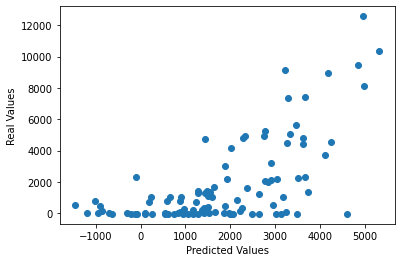

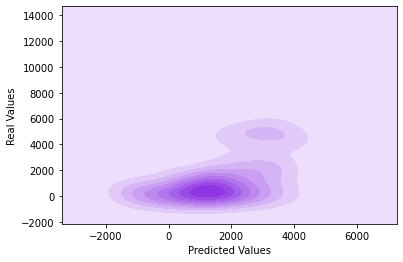

In [40]:
plot_result(lasso_preds, training_outputs)

# **3. Polynomial Regression**

In [0]:
def poly_reg(X, y, degree=2, n_splits=5):
  
  poly_features = PolynomialFeatures(degree=degree)

  X = poly_features.fit_transform(X)
  polynomial_model = LinearRegression()

  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  r_squares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  
    polynomial_model.fit(X_train, y_train)

    # calculate R^2 value
    r_square = polynomial_model.score(X_test, y_test)
    r_squares.append(r_square)

    # get the predictions
    predictions = np.append(predictions, polynomial_model.predict(X_test))

  # calculate mean of r square values
  r_square = np.mean(r_squares)

  return r_square, predictions


In [228]:
r_square, poly_preds = poly_reg(training_inputs, training_outputs, degree=2, n_splits=4)

print("Cross validation R^2: {}".format(r_square))

Cross validation R^2: 0.46101400795870107


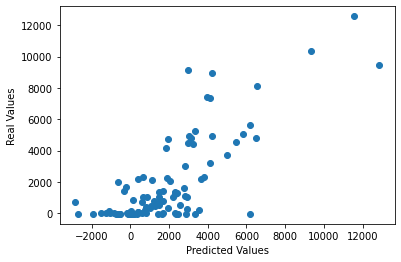

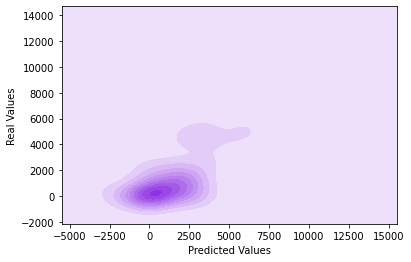

In [229]:
plot_result(poly_preds, training_outputs)

# **4. K-Nearest Neighbors**

In [0]:
def knn(X, y, algorithm="auto", n_neighbors=5, n_splits=5):
  
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, algorithm=algorithm)

  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  r_squares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  
    knn.fit(X_train, y_train)

    # calculate R^2 value
    r_square = knn.score(X_test, y_test)
    r_squares.append(r_square)

    # get the predictions
    predictions = np.append(predictions, knn.predict(X_test))

  # calculate mean of r square values
  r_square = np.mean(r_squares)

  return r_square, predictions

In [58]:
best_n_neighbors = 0
best_r_square = 0

for i in range(1, 20):

  r_square, knn_preds = knn(
      training_inputs, 
      training_outputs, 
      algorithm="brute", 
      n_neighbors=i,
      n_splits=4)

  if r_square > best_r_square:

    best_r_square = r_square
    best_n_neighbors = i
  
  print("{}- R^2: {}".format(i, r_square))

1- R^2: -0.12622874815092738
2- R^2: -0.0804755489828818
3- R^2: -0.12246413764828487
4- R^2: 0.12245753795171604
5- R^2: 0.15748506832077552
6- R^2: 0.14656895953765783
7- R^2: 0.12351466971426311
8- R^2: 0.13339119136624256
9- R^2: 0.16527475742370124
10- R^2: 0.17044330671729585
11- R^2: 0.1194315788812077
12- R^2: 0.11383038882601695
13- R^2: 0.10789210950758366
14- R^2: 0.10336383539774455
15- R^2: 0.11717120056870944
16- R^2: 0.10257666581125435
17- R^2: 0.10100522291764064
18- R^2: 0.10502952390364612
19- R^2: 0.09721844836167509


In [234]:
r_square, knn_preds = knn(
      training_inputs, 
      training_outputs, 
      algorithm="brute", 
      n_neighbors=best_n_neighbors,
      n_splits=4)

print("Number of neighbors: {}\nR^2: {}".format(best_n_neighbors, r_square))

Number of neighbors: 10
R^2: 0.17044330671729585


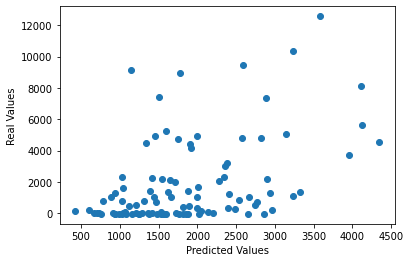

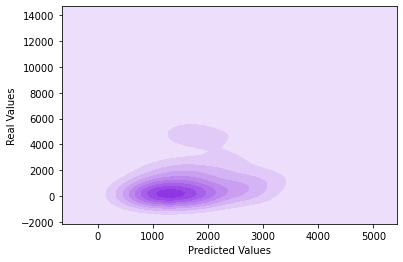

In [61]:
plot_result(knn_preds, training_outputs)

# **5. Deep Neural Networks**

**Build neural network**

In [0]:
def build_model():
  NN_model = tf.keras.Sequential()

  NN_model.add(tf.keras.layers.Dense(50, input_dim=5, kernel_initializer="normal", activation="relu"))
  NN_model.add(tf.keras.layers.Dense(40, kernel_initializer="normal", activation="relu"))
  NN_model.add(tf.keras.layers.Dense(1, kernel_initializer="normal", activation="linear"))

  NN_model.compile(
      optimizer=tf.keras.optimizers.Adam(), 
      loss="mse",
      metrics=["mse", "mae"]
  )

  return NN_model

In [0]:
# Normalize the data for training the model

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

x = training_inputs
y = np.reshape(training_outputs, (-1, 1))

scaler_X.fit(x)
scaler_Y.fit(y)

xscale = scaler_X.transform(x)
yscale = scaler_Y.transform(y)

In [0]:
NN_model = build_model()

history = NN_model.fit(
        xscale,
        yscale,
        epochs=200,
        batch_size=80,
        validation_split=0.2,
        verbose=0,
    )

In [633]:
xtest = scaler_X.transform(test_inputs)

preds = NN_model.predict(xtest)

final_prediction = scaler_Y.inverse_transform(preds).astype("int")
print(final_prediction)

[[ 6950]
 [  426]
 [ 3847]
 [ 2068]
 [  121]
 [  134]
 [   98]
 [ 5861]
 [10788]
 [ 5716]
 [  698]
 [  641]
 [ 1984]
 [ 1747]
 [ 1670]
 [10344]
 [   68]
 [  582]
 [   86]
 [   54]]


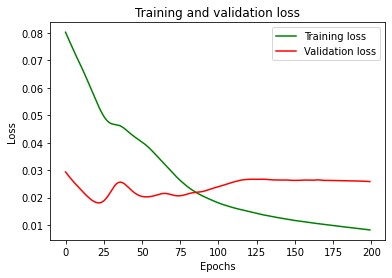

In [634]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [635]:
NN_preds = NN_model.predict(xscale)
NN_preds = scaler_Y.inverse_transform(NN_preds).T

r_square = 1 - ( np.sum(np.square(training_outputs - NN_preds)) / np.sum(np.square(training_outputs - np.mean(training_outputs))))
print("R^2: {}".format(r_square))

R^2: 0.7449128050389286


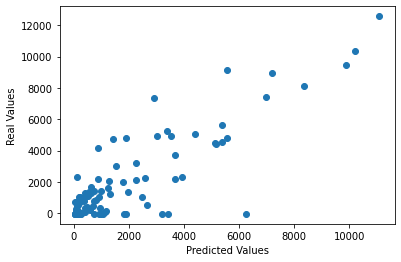

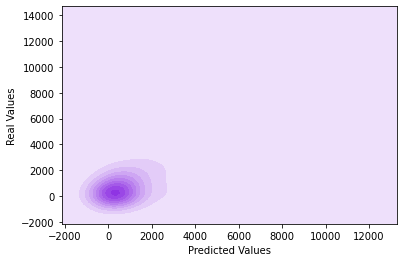

In [636]:
plot_result(NN_preds, training_outputs)

# **Final Prediction On The Test Data**

In [0]:
def write_to_excel(data):

  wb = Workbook()

  sheet = wb.add_sheet("Prediction")

  for i, v in enumerate(data):
    
    sheet.write(i, 0, str(v))

  wb.save("prediction.xls")